In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.0 MB/s eta 0:00:00


In [1]:

import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop, RandomContrast,RandomTranslation
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc
from collections import Counter
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
import keras_tuner
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras import Input
from sklearn.svm import SVC
from keras.saving import register_keras_serializable
from tensorflow.keras import layers, Model, Input
import keras_tuner as kt
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import regularizers
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.patches as patches
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split

# Part 1:  Data Analysis





In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_path = r'/content/drive/MyDrive/RealWaste 1'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=32

)


Found 3734 files belonging to 8 classes.


In [3]:
class_names = sorted(os.listdir(data_path))
num_classes = len(class_names)
class_counts = np.zeros(num_classes)

In [4]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomBrightness(0.2),
    RandomCrop(224, 224),
])

def augment(image, label):

    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label



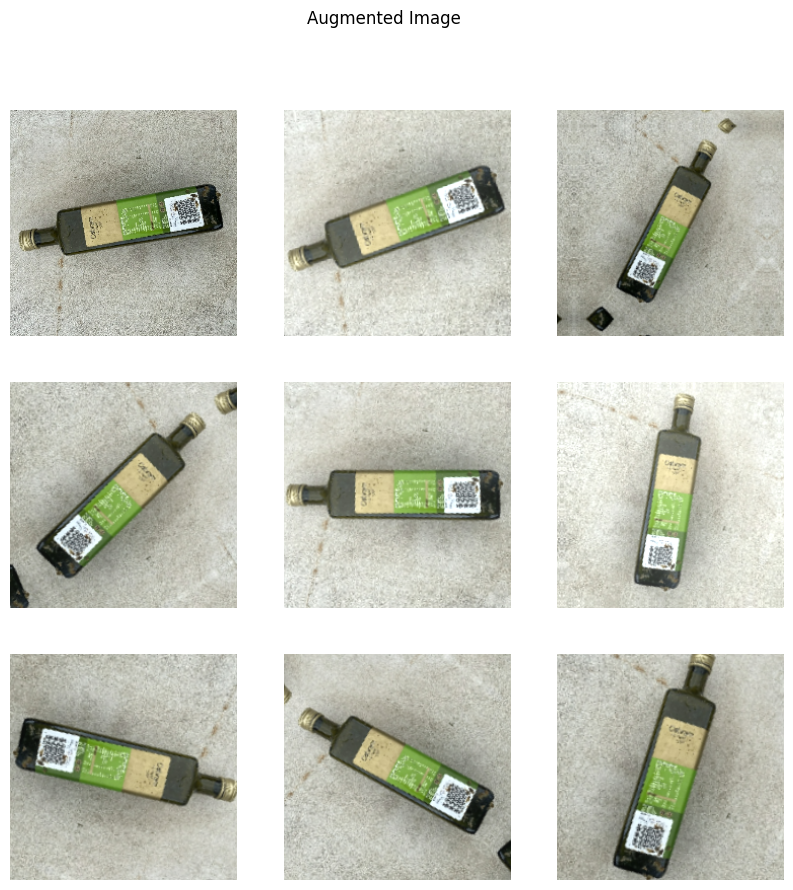

In [5]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]


    augmented_images = [image]
    for _ in range(8):
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])


    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")
    plt.suptitle('Augmented Image')
    plt.show()


visualize_dataset(dataset, class_names)

In [6]:

def normalize_and_encode(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label


In [7]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [8]:

shuffled_dataset = dataset.shuffle(buffer_size=dataset_size, seed=42)


train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)

train_dataset = shuffled_dataset.take(train_size).map(augment).map(normalize_and_encode)
remaining_dataset = shuffled_dataset.skip(train_size)
val_dataset = remaining_dataset.take(val_size).map(normalize_and_encode)
test_dataset = remaining_dataset.skip(val_size).map(normalize_and_encode)

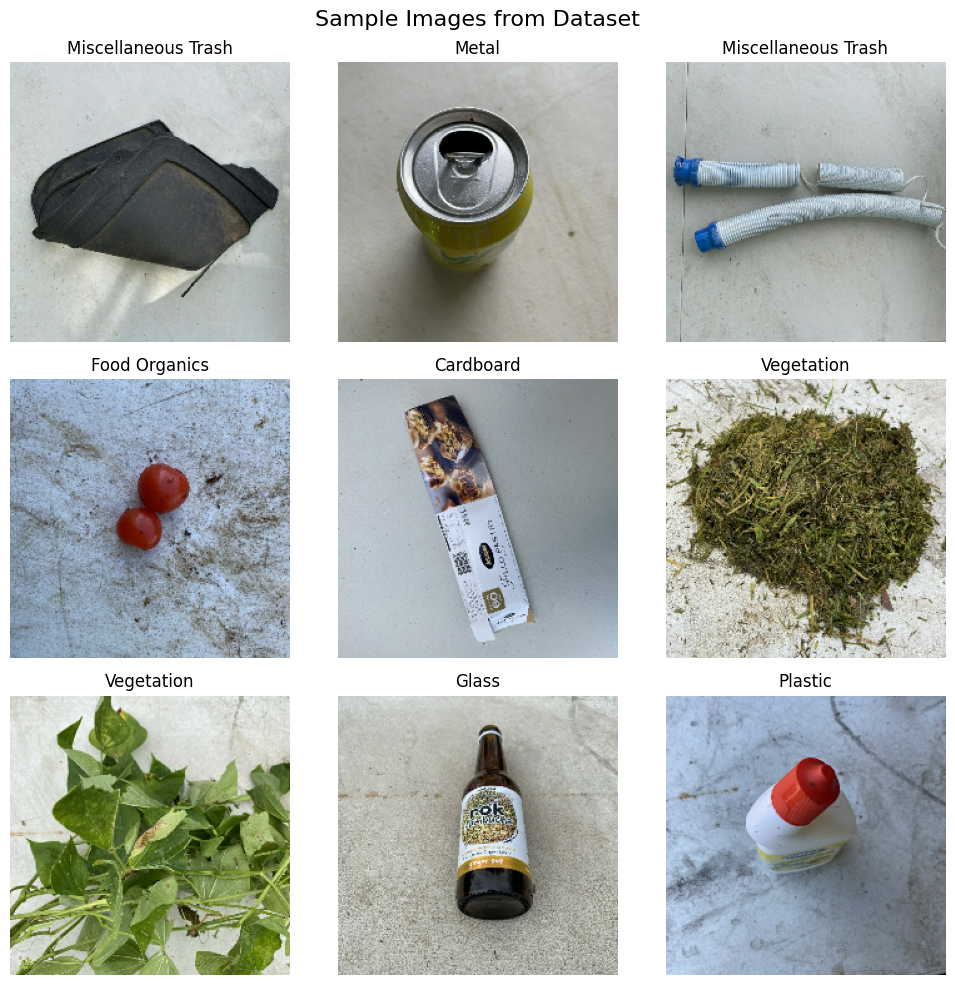

In [9]:
plt.figure(figsize=(10, 10))


for images, labels in dataset.take(1):
  for i in range(9):
    image = images[i]
    label_idx = labels[i].numpy()

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(class_names[label_idx])
    plt.axis("off")

plt.suptitle("Sample Images from Dataset", fontsize=16)
plt.tight_layout()
plt.show()

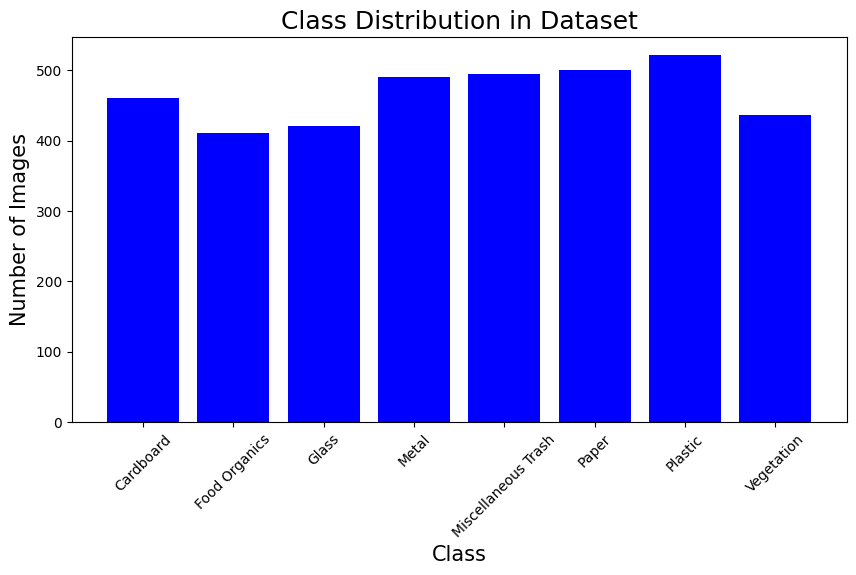

In [10]:



class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}


plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

# Part 2: EfficientNet B0

In [13]:

def scheduler(epoch, lr):
    min_lr = 1e-5
    if epoch < 5:
        return lr
    else:
        new_lr = float(lr * tf.math.exp(-0.1))
        return max(new_lr, min_lr)
lr_scheduler = LearningRateScheduler(scheduler)


In [14]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
    verbose=1
)

In [17]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [18]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = True


model_base = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.60),
    layers.Dense(256, activation="relu",),
    layers.Dense(8, activation="softmax")
])


model_base.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
              loss= 'CategoricalCrossentropy',
              metrics=["accuracy"])


history_base_model = model_base.fit(train_dataset, validation_data=val_dataset, epochs=35,  callbacks=[ lr_scheduler, reduce_lr])



Epoch 1/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 152s 909ms/step - accuracy: 0.2249 - loss: 2.6282 - val_accuracy: 0.1423 - val_loss: 2.1256 - learning_rate: 1.0000e-04
Epoch 2/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 44s 468ms/step - accuracy: 0.5174 - loss: 1.4341 - val_accuracy: 0.1311 - val_loss: 2.2298 - learning_rate: 1.0000e-04
Epoch 3/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 450ms/step - accuracy: 0.6185 - loss: 1.1061 - val_accuracy: 0.1526 - val_loss: 2.5061 - learning_rate: 1.0000e-04
Epoch 4/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 43s 453ms/step - accuracy: 0.6930 - loss: 0.9224 - val_accuracy: 0.1948 - val_loss: 2.5602 - learning_rate: 1.0000e-04
Epoch 5/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 43s 452ms/step - accuracy: 0.7302 - loss: 0.7818 - val_accuracy: 0.2584 - val_loss: 2.5680 - learning_rate: 5.0000e-05
Epoch 6/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 445ms/step - accuracy: 0.7580 - loss: 0.7131 - val_accuracy: 0.3566 - val_loss: 1.8130 - learning_rate: 4.5242e-05
Epoch 7/35
81/81 ━━━━━━━━━━━━━━━━━━━━ 46s 495ms/step - ac

In [19]:
model_base.save('/content/drive/MyDrive/my_basemodel.keras')

In [20]:

y_true_base = []
y_pred_probs_base = []

for images, labels in val_dataset:
    preds = model_base.predict(images)
    y_true_base.extend(labels.numpy())
    y_pred_probs_base.extend(preds)

y_pred_probs_base = np.array(y_pred_probs_base)
y_true_base = np.array(y_true_base)


y_pred_base = np.argmax(y_pred_probs_base, axis=1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


In [21]:

if y_pred_base.ndim > 1:
    y_pred_base = np.argmax(y_pred_base, axis=1)


if y_true_base.ndim > 1:
    y_true_base = np.argmax(y_true_base, axis=1)


print(classification_report(y_true_base, y_pred_base))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85        64
           1       0.89      0.92      0.90        62
           2       0.93      0.82      0.87        50
           3       0.86      0.88      0.87        65
           4       0.90      0.78      0.83        81
           5       0.79      0.95      0.86        77
           6       0.99      0.86      0.92        79
           7       0.90      0.94      0.92        66

    accuracy                           0.88       544
   macro avg       0.88      0.88      0.88       544
weighted avg       0.88      0.88      0.88       544



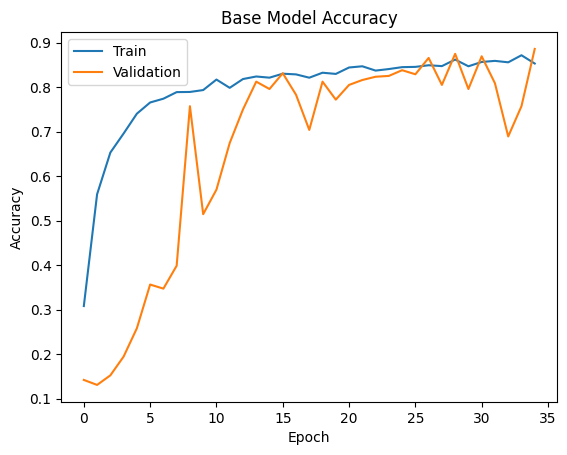

In [22]:
def plot_hist(history):
    plt.plot(history_base_model.history["accuracy"])
    plt.plot(history_base_model.history["val_accuracy"])
    plt.title("Base Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history_base_model)

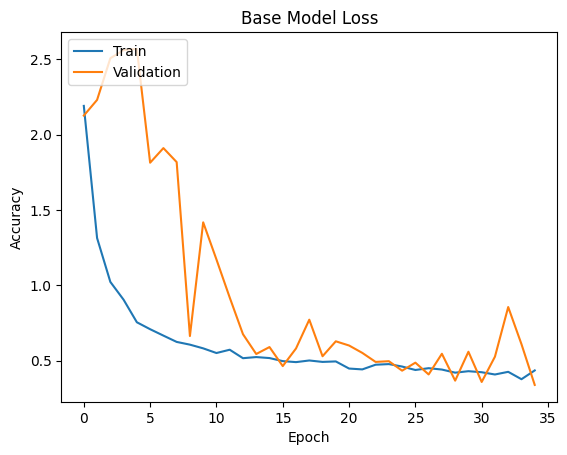

In [23]:
def plot_hist(history):
    plt.plot(history_base_model.history["loss"])
    plt.plot(history_base_model.history["val_loss"])
    plt.title("Base Model Loss")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history_base_model)

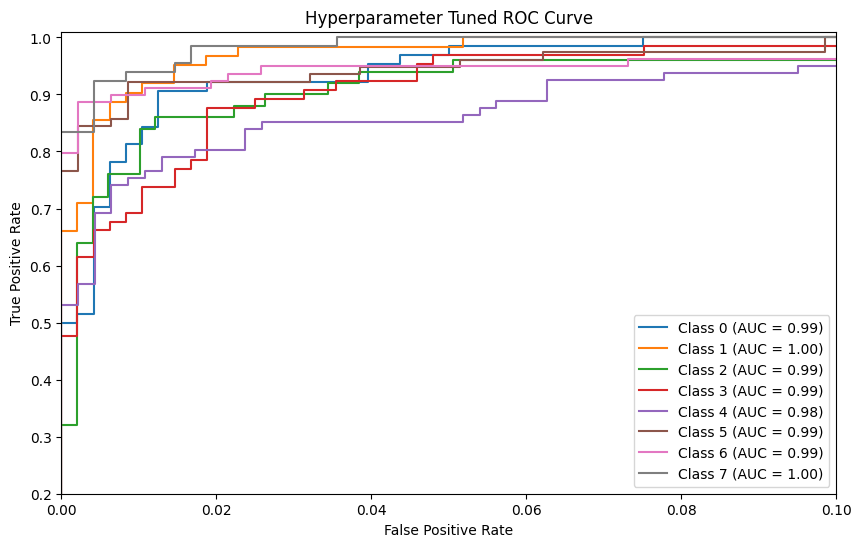

In [88]:
num_classes = 8
y_true_one_hot = to_categorical(y_true_base, num_classes)

plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs_base[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.xlim([0.0, 0.1])
plt.ylim([0.2, 1.01])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Hyperparameter Tuned ROC Curve")
plt.legend(loc='lower right')
plt.show()

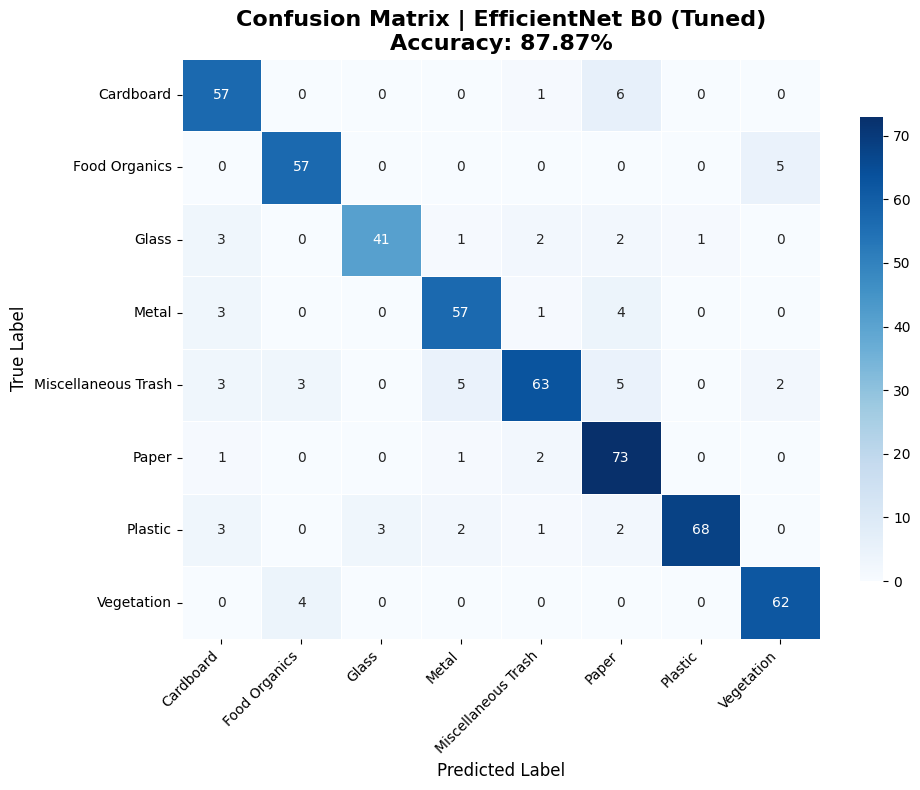

In [83]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name="EfficientNet B0"):
    cm = confusion_matrix(y_true_base, y_pred_base)
    acc = accuracy_score(y_true_base, y_pred_base) * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8})

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix | {model_name}\nAccuracy: {acc:.2f}%", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(y_true_base, y_pred_base, class_names, model_name="EfficientNet B0 (Tuned)")

In [27]:

test_loss_base, test_acc_base = model_base.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc_base:.4f}")
print(f"Test Loss: {test_loss_base:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.8605 - loss: 0.4006
Test Accuracy: 0.8405
Test Loss: 0.4225


In [28]:
model_base = load_model(
    "/content/drive/MyDrive/my_basemodel.keras",
)

In [29]:

def classify_from_dataset(model, test_dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))

    for images, labels in test_dataset.take(1):
        predictions = model_base.predict(images, verbose=0)

        for i in range(min(num_images, len(images))):
            image = images[i]
            true_label = tf.argmax(labels[i]).numpy()
            prob_vector = predictions[i]
            pred_label = np.argmax(prob_vector)

            ax = plt.subplot(3, 3, i + 1)


            img = image.numpy()
            if img.max() <= 1.0:
                img = (img * 255).astype("uint8")
            else:
                img = img.astype("uint8")

            ax.imshow(img)
            ax.axis("off")


            title_color = "green" if pred_label == true_label else "red"
            ax.set_title(
                f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}",
                fontsize=10,
                color=title_color
            )


            top3 = np.argsort(prob_vector)[-3:][::-1]
            prob_text = "\n".join([f"{class_names[j]}: {prob_vector[j]*100:.1f}%" for j in top3])
            ax.text(0.5, -0.25, prob_text, transform=ax.transAxes,
                    ha='center', va='top', fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.suptitle("Efficientnet B0 Classification with Top 3 Probabilities", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


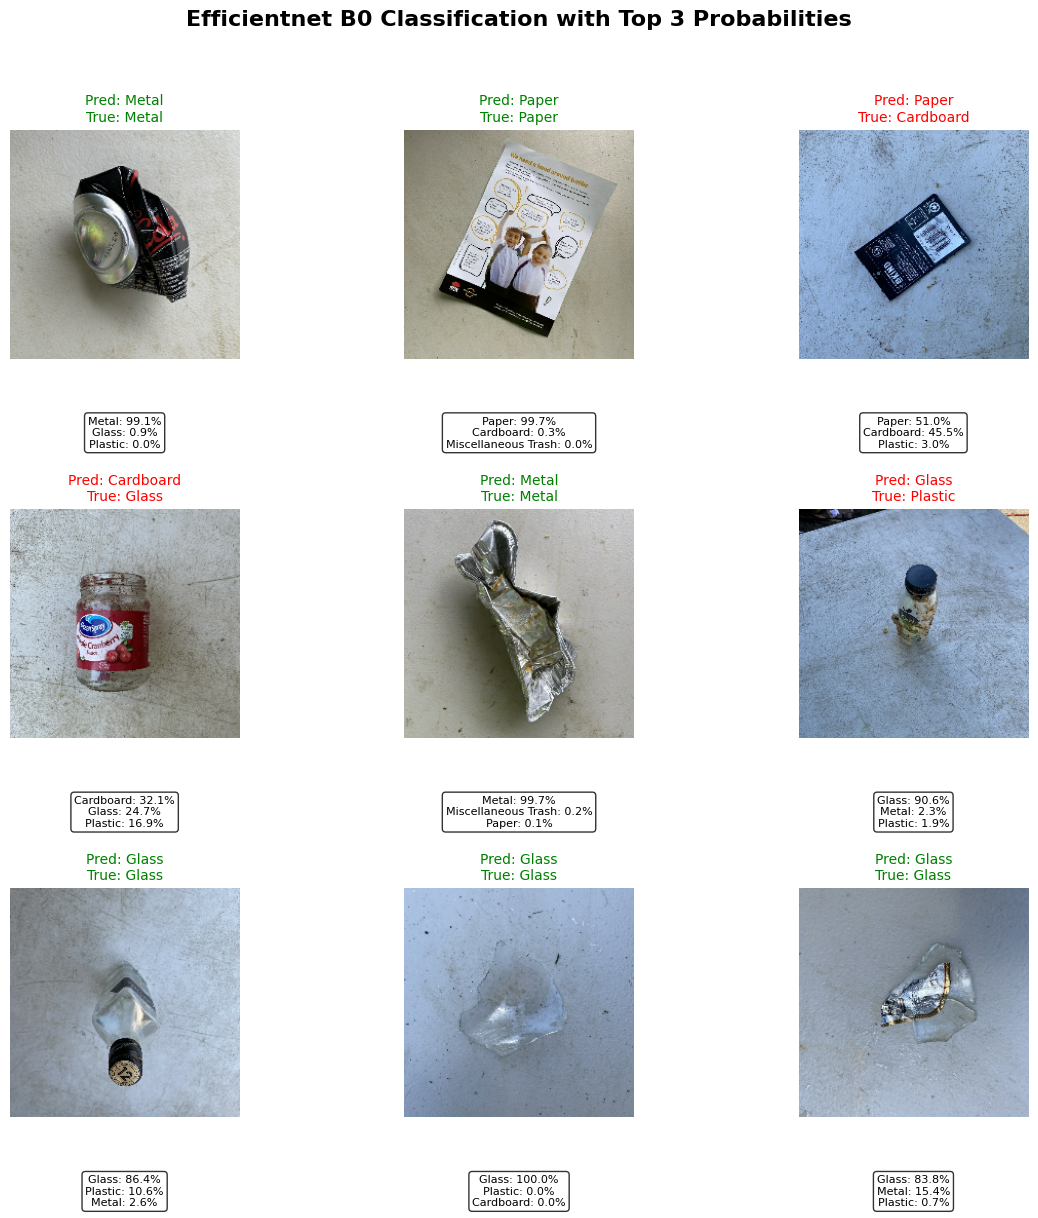

In [30]:
classify_from_dataset(model_base, test_dataset, class_names)


# Part 3: Hyperparameter Tuned EfficientNet B0

In [31]:

def build_model(hp):
    base_model = keras.applications.EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


    trainable = hp.Boolean('trainable', default=False)
    base_model.trainable = trainable

    if trainable:
        num_unfrozen_layers = hp.Int("unfreeze_layers", min_value=5, max_value=10, step=2)
        for layer in base_model.layers[-num_unfrozen_layers:]:
            layer.trainable = True


    optimizer_choice = hp.Choice("optimizer", ["adam", "sgd", "rmsprop"])
    optimizer = {
        "adam": keras.optimizers.Adam,
        "sgd": keras.optimizers.SGD,
        "rmsprop": keras.optimizers.RMSprop
    }[optimizer_choice](learning_rate=hp.Choice("learning_rate", [1e-3, 1e-4, 1e-5, 1e-6]))

    model_tuned = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dropout(hp.Float("dropout_rate", min_value=0.4, max_value=0.8, step=0.1)),
        layers.Dense(hp.Int("units", min_value=64, max_value=512, step=64),
                     activation=hp.Choice("activation", ["relu", "elu", "swish"]),
                     kernel_regularizer=tf.keras.regularizers.l2(
                         hp.Float("l2", min_value=0.001, max_value=0.01, step=0.001))),
        layers.Dense(8, activation="softmax")
    ])

    model_tuned.compile(
        optimizer=optimizer,
        loss='CategoricalCrossentropy',
        metrics=["accuracy"]
    )
    return model_tuned



In [38]:
rm -rf hyperparameter_tuning/efficientnet_tuning/


In [39]:
tuner = keras_tuner.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=2,
    directory="hyperparameter_tuning",
    project_name="efficientnet_tuning"
)


In [41]:
tuner.search(train_dataset, validation_data=val_dataset, epochs=15, callbacks=[ lr_scheduler])


best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]




Trial 5 Complete [00h 23m 12s]
val_accuracy: 0.17003676295280457

Best val_accuracy So Far: 0.3125000074505806
Total elapsed time: 01h 54m 37s


In [42]:
best_model = tuner.hypermodel.build(best_hp)
history_tuned = best_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=40,
    callbacks=[ lr_scheduler, reduce_lr]
)


Epoch 1/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 112s 483ms/step - accuracy: 0.5013 - loss: 2.9540 - val_accuracy: 0.1287 - val_loss: 3.5524 - learning_rate: 0.0010
Epoch 2/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 72s 818ms/step - accuracy: 0.7336 - loss: 2.0101 - val_accuracy: 0.1423 - val_loss: 3.4020 - learning_rate: 0.0010
Epoch 3/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 443ms/step - accuracy: 0.7962 - loss: 1.6711 - val_accuracy: 0.1305 - val_loss: 5.9118 - learning_rate: 0.0010
Epoch 4/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 41s 441ms/step - accuracy: 0.8607 - loss: 1.3304 - val_accuracy: 0.1360 - val_loss: 3.8847 - learning_rate: 0.0010
Epoch 5/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 445ms/step - accuracy: 0.8480 - loss: 1.2032 - val_accuracy: 0.1760 - val_loss: 3.4170 - learning_rate: 0.0010
Epoch 6/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 443ms/step - accuracy: 0.8675 - loss: 1.0305 - val_accuracy: 0.2500 - val_loss: 4.0732 - learning_rate: 4.5242e-04
Epoch 7/40
81/81 ━━━━━━━━━━━━━━━━━━━━ 42s 443ms/step - accuracy: 0.9199 - los

In [51]:
best_model.save('/content/drive/MyDrive/my_hyperparameter_model.keras')

In [44]:
tuner.results_summary()


Results summary
Results in hyperparameter_tuning/efficientnet_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
trainable: True
optimizer: adam
learning_rate: 0.001
dropout_rate: 0.4
units: 192
activation: swish
l2: 0.004
unfreeze_layers: 5
Score: 0.3125000074505806

Trial 3 summary
Hyperparameters:
trainable: True
optimizer: sgd
learning_rate: 0.0001
dropout_rate: 0.4
units: 384
activation: swish
l2: 0.009000000000000001
unfreeze_layers: 7
Score: 0.203125

Trial 4 summary
Hyperparameters:
trainable: False
optimizer: rmsprop
learning_rate: 0.0001
dropout_rate: 0.5
units: 64
activation: relu
l2: 0.004
unfreeze_layers: 7
Score: 0.17003676295280457

Trial 1 summary
Hyperparameters:
trainable: False
optimizer: sgd
learning_rate: 1e-05
dropout_rate: 0.4
units: 448
activation: relu
l2: 0.004
unfreeze_layers: 5
Score: 0.160845585167408

Trial 2 summary
Hyperparameters:
trainable: False
optimizer: sgd
learning_rate: 0.001
dropout_ra

In [57]:

y_true = []
y_pred_probs= []

for images, labels in val_dataset:
    preds = best_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred_probs.extend(preds)

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)


y_pred = np.argmax(y_pred_probs, axis=1)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


In [60]:
if y_pred.ndim > 1:
    y_pred = np.argmax(y_pred, axis=1)


if y_true.ndim > 1:
    y_true = np.argmax(y_true, axis=1)


print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.93      0.96        60
           1       1.00      0.97      0.99        68
           2       0.95      0.97      0.96        60
           3       0.94      1.00      0.97        81
           4       0.97      0.97      0.97        69
           5       0.94      0.97      0.96        69
           6       1.00      0.93      0.96        73
           7       0.95      0.98      0.96        54

    accuracy                           0.97       534
   macro avg       0.97      0.97      0.97       534
weighted avg       0.97      0.97      0.97       534



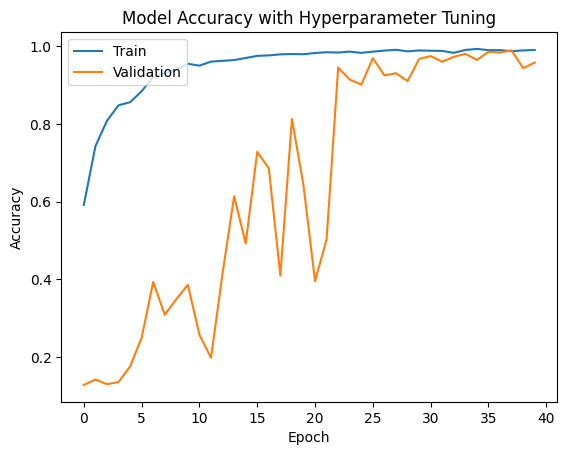

In [61]:
def plot_hist(history):
    plt.plot(history_tuned.history["accuracy"])
    plt.plot(history_tuned.history["val_accuracy"])
    plt.title("Model Accuracy with Hyperparameter Tuning")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history_tuned)

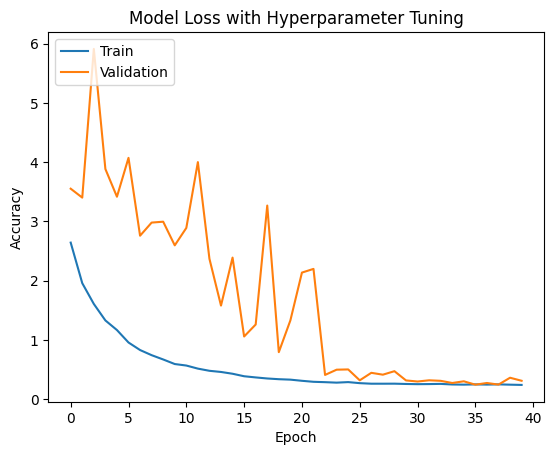

In [48]:
def plot_hist(history_tuned):
    plt.plot(history_tuned.history["loss"])
    plt.plot(history_tuned.history["val_loss"])
    plt.title("Model Loss with Hyperparameter Tuning")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


plot_hist(history_tuned)

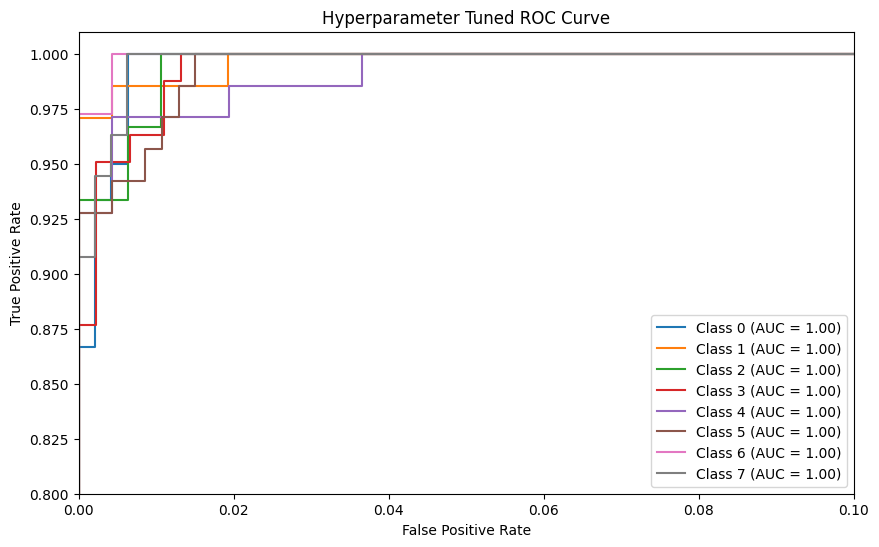

In [72]:
num_classes = 8
y_true_one_hot = to_categorical(y_true, num_classes)

plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')


plt.xlim([0.0, 0.1])
plt.ylim([0.8, 1.01])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Hyperparameter Tuned ROC Curve")
plt.legend(loc='lower right')
plt.show()

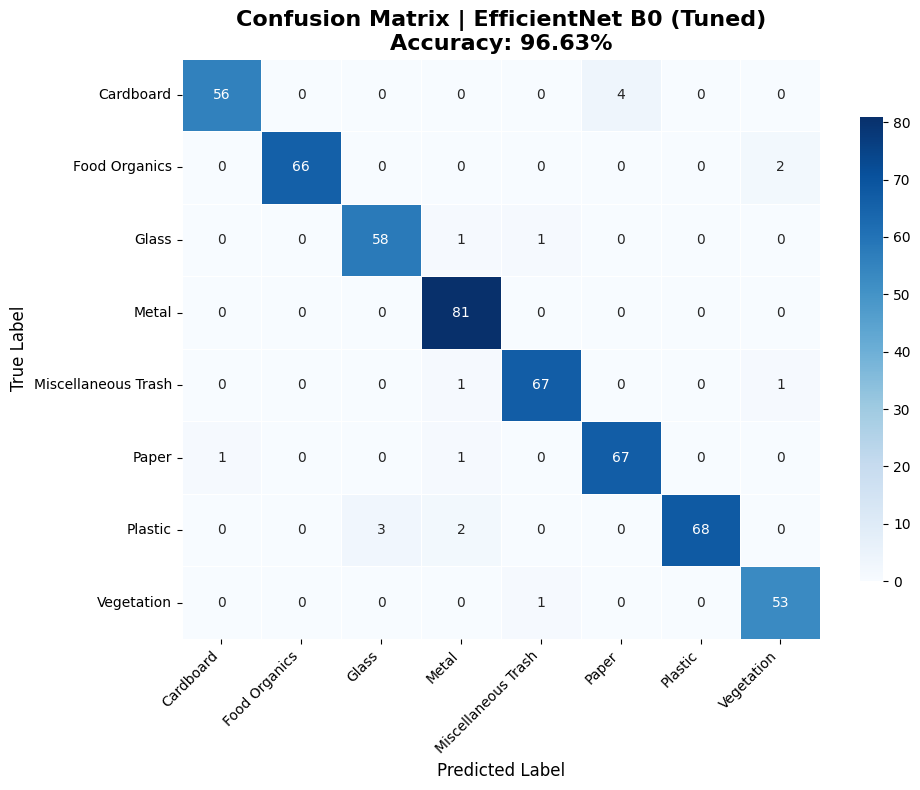

In [81]:
def plot_confusion_matrix(y_true, y_pred, class_names, model_name="EfficientNet B0 (Tuned)"):
    cm = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred) * 100

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", linewidths=0.5,
                xticklabels=class_names, yticklabels=class_names, cbar_kws={'shrink': 0.8})

    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.title(f"Confusion Matrix | {model_name}\nAccuracy: {acc:.2f}%", fontsize=16, fontweight='bold')
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(y_true, y_pred, class_names, model_name="EfficientNet B0 (Tuned)")

In [53]:
model = load_model("/content/drive/MyDrive/my_hyperparameter_model.keras")
test_loss_tuned, test_acc_tuned = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_acc_tuned:.4f}")
print(f"Test Loss: {test_loss_tuned:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 219 variables whereas the saved optimizer has 436 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


19/19 ━━━━━━━━━━━━━━━━━━━━ 14s 34ms/step - accuracy: 0.9571 - loss: 0.3055
Test Accuracy: 0.9688
Test Loss: 0.2972


In [74]:

def classify_from_dataset(model, test_dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))

    for images, labels in test_dataset.take(1):
        predictions = model.predict(images, verbose=0)

        for i in range(min(num_images, len(images))):
            image = images[i]
            true_label = tf.argmax(labels[i]).numpy()
            prob_vector = predictions[i]
            pred_label = np.argmax(prob_vector)

            ax = plt.subplot(3, 3, i + 1)


            img = image.numpy()
            if img.max() <= 1.0:
                img = (img * 255).astype("uint8")
            else:
                img = img.astype("uint8")

            ax.imshow(img)
            ax.axis("off")


            title_color = "green" if pred_label == true_label else "red"
            ax.set_title(
                f"Pred: {class_names[pred_label]}\nTrue: {class_names[true_label]}",
                fontsize=10,
                color=title_color
            )


            top3 = np.argsort(prob_vector)[-3:][::-1]
            prob_text = "\n".join([f"{class_names[j]}: {prob_vector[j]*100:.1f}%" for j in top3])
            ax.text(0.5, -0.25, prob_text, transform=ax.transAxes,
                    ha='center', va='top', fontsize=8,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    plt.suptitle("Hyperparameter Tuned Efficientnet B0 Classification with Top 3 Probabilities", fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


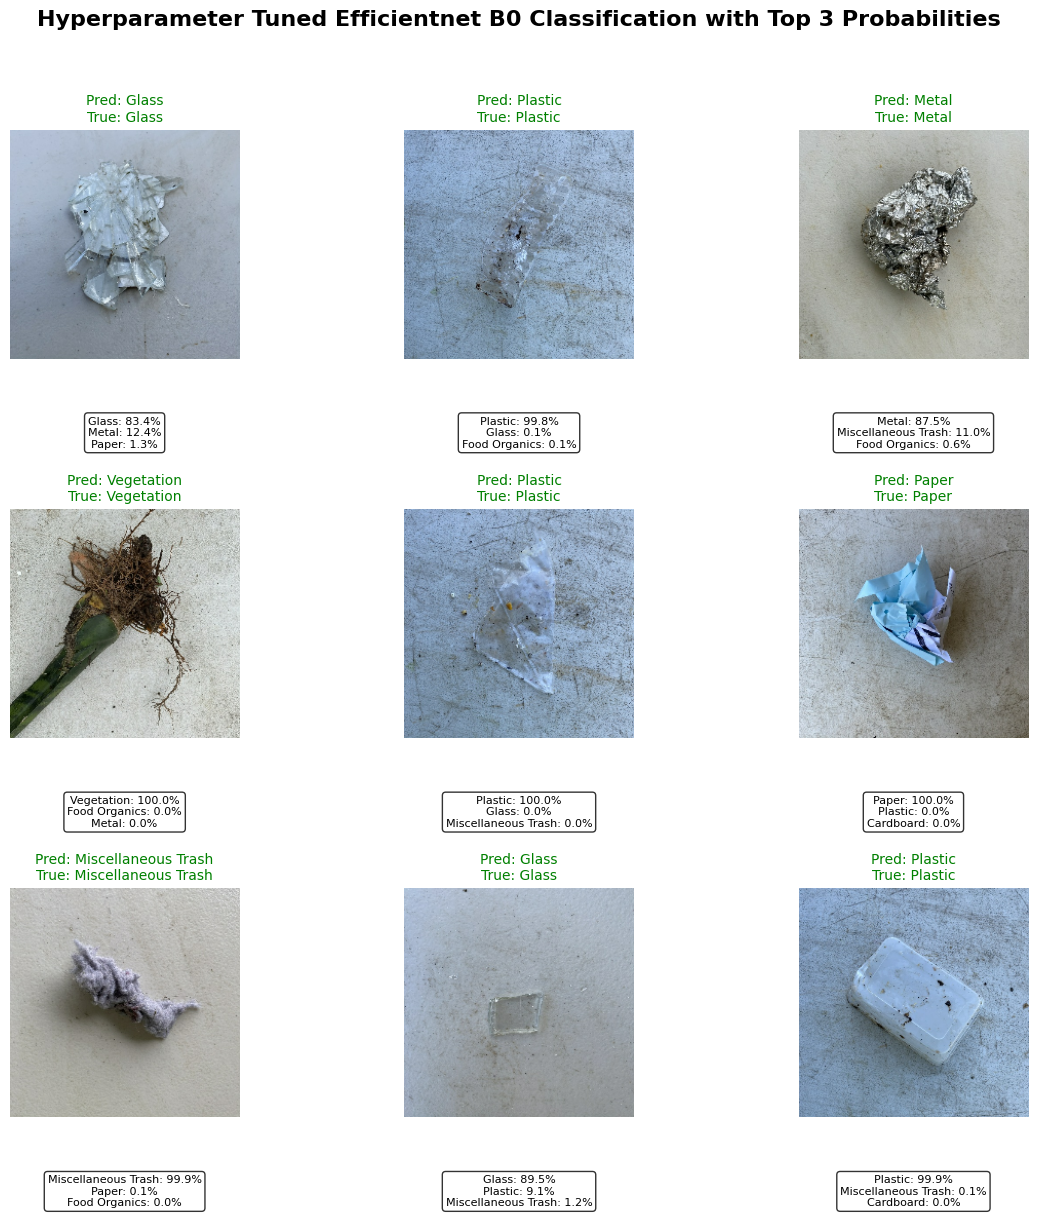

In [76]:
classify_from_dataset(model, test_dataset, class_names)
